## Assignment

#### Imports

In [11]:
import pydicom
from pathlib import Path
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

### Read all files

In [12]:
# Folder = Path(r"C:\University\COOP\Hospital Summer 2025\Python Stuff\InitialAssignment\DICOM")
Folder = Path(f"{Path().resolve()}/DICOM")

CT_File_Names = []
RD_File_Names = []
RP_File_Names = []
RS_File_Names = []

CT_Files = []
RD_Files = []
RP_Files = []
RS_Files = []

for file in Folder.glob("*.dcm"):
    if file.is_file():
        # print(f"Found file: {file.name}")
        try:
            if "CT" in file.name.upper() and pydicom.dcmread(file, stop_before_pixels=True).Modality == 'CT':
                CT_Files.append(pydicom.dcmread(file)) 
                CT_File_Names.append(file)
            elif "RD" in file.name.upper() and pydicom.dcmread(file, stop_before_pixels=True).Modality == 'RTDOSE':
                RD_Files.append(pydicom.dcmread(file))
                RD_File_Names.append(file)
            elif "RP" in file.name.upper() and pydicom.dcmread(file, stop_before_pixels=True).Modality == 'RTPLAN':
                RP_Files.append(pydicom.dcmread(file))
                RP_File_Names.append(file)
            elif "RS" in file.name.upper() and pydicom.dcmread(file, stop_before_pixels=True).Modality == 'RTSTRUCT':
                RS_Files.append(pydicom.dcmread(file))
                RS_File_Names.append(file)
            else:
                print(f"Unknown DICOM file {file.name}")
        except:
            print(f"Skipped invalid DICOM: {file.name}")

print(f"Found {len(CT_Files)+len(RD_Files)+len(RP_Files)+len(RS_Files)} valid dcm files")

Skipped invalid DICOM: CT1.2.752.243.1.1.20250506090153570.2410.25026.dcm
Found 159 valid dcm files


### Plot gantry position as function of control point

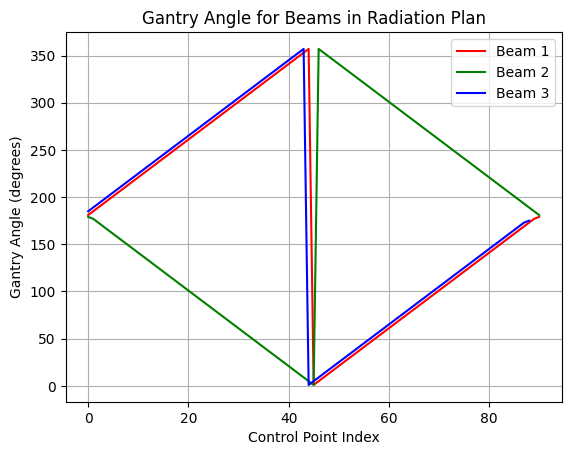

In [13]:
Beams = RP_Files[0].BeamSequence # only 1 radiation plan
gantry_angles = np.full((len(Beams), len(Beams[0].ControlPointSequence)), np.nan) # pre-allocating

for i, beam in enumerate(Beams):
    for j, controlpoint in enumerate(beam.ControlPointSequence):
        gantry_angles[i, j] = controlpoint.GantryAngle

colours = ['red', 'green', 'blue']

for i in range(np.shape(gantry_angles)[0]):
    plt.plot(gantry_angles[i], label=f"Beam {i+1}", color = colours[i])

plt.legend()
plt.xlabel("Control Point Index")
plt.ylabel("Gantry Angle (degrees)")
plt.title("Gantry Angle for Beams in Radiation Plan")
plt.grid(True)
plt.show()

### Plot 2D view of MLCs (Multi-Leaf Collimators) for one control point

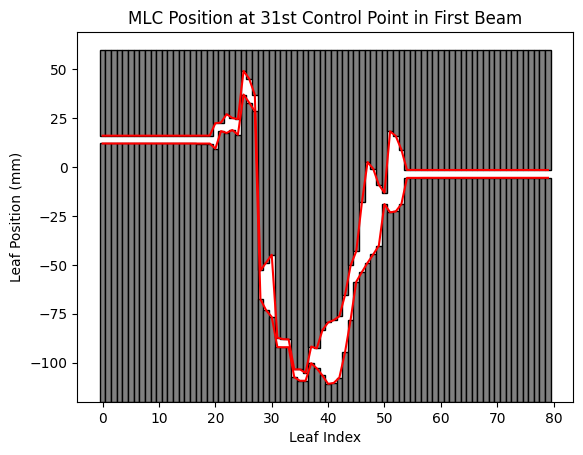

In [14]:
Beams = RP_Files[0].BeamSequence # only 1 radiation plan

beam = Beams[0] # only looking at beam 1 for now

controlpoint = beam.ControlPointSequence[0] # only looking at first control point for now

for device in controlpoint.BeamLimitingDevicePositionSequence:
    if device.RTBeamLimitingDeviceType == "MLCX":
        MLC_positons = device.LeafJawPositions
        MLC_DOWN = MLC_positons[:len(MLC_positons)//2]
        MLC_UP = MLC_positons[len(MLC_positons)//2:]
        plt.plot(MLC_DOWN, color = 'red')
        plt.plot(MLC_UP, color = 'red')
        min_height = -120
        plt.bar(np.arange(len(MLC_DOWN)), height = [leaf - min_height for leaf in MLC_DOWN], width=1.0, bottom=min_height, color='grey', edgecolor = 'black')
        max_height = 60
        plt.bar(np.arange(len(MLC_UP)), height = [max_height - leaf for leaf in MLC_UP], width=1.0, bottom = MLC_UP, color = 'grey', edgecolor = 'black')
        plt.xlabel('Leaf Index')
        plt.ylabel('Leaf Position (mm)')
        plt.title(f"MLC Position at 31st Control Point in First Beam")

        



### Plot the MUs as a function of control point

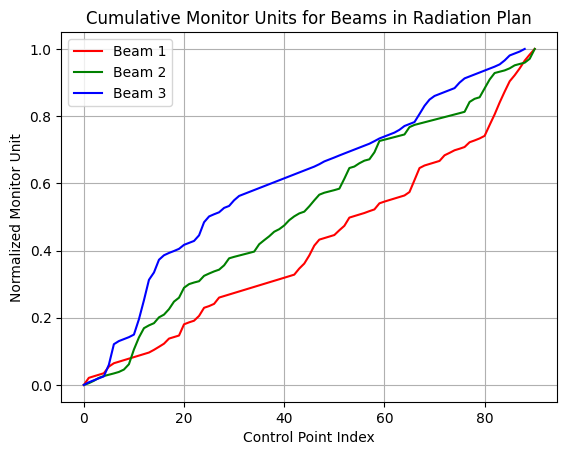

In [15]:
Beams = RP_Files[0].BeamSequence # only 1 radiation plan
monitor_units = np.full((len(Beams), len(Beams[0].ControlPointSequence)), np.nan) # pre-allocating

for i, beam in enumerate(Beams):
    for j, controlpoint in enumerate(beam.ControlPointSequence):
        monitor_units[i, j] = controlpoint.CumulativeMetersetWeight

colours = ['red', 'green', 'blue']

for i in range(np.shape(monitor_units)[0]):
    plt.plot(monitor_units[i], label=f"Beam {i+1}", color = colours[i])

plt.legend()
plt.xlabel("Control Point Index")
plt.ylabel("Normalized Monitor Unit")
plt.title("Cumulative Monitor Units for Beams in Radiation Plan")
plt.grid(True)
plt.show()

### Plot the slice at isocentre of the CT in all three planes (coronal, sagittal and axial) labeled properly

Text(1642.8692810457517, 0.5, 'Z (Voxels)')

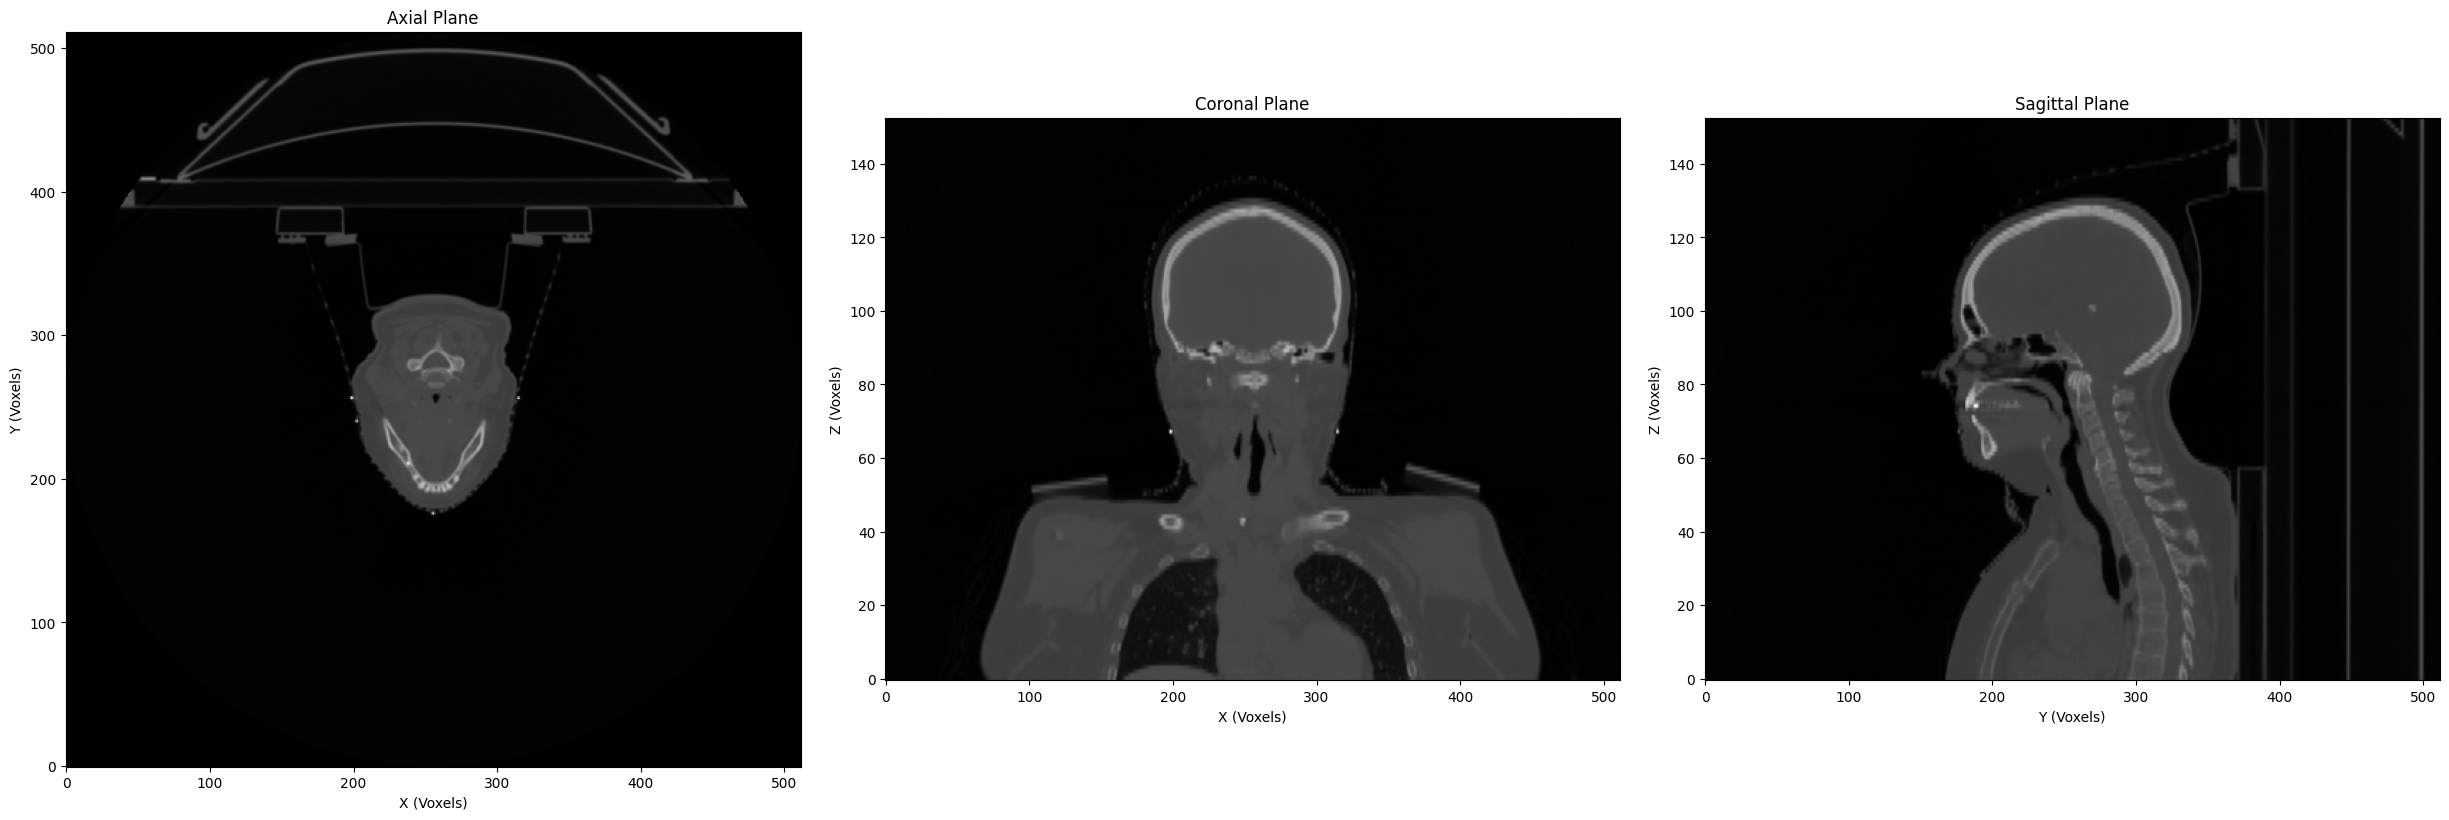

In [83]:
Sorted_CT_Files = sorted(CT_Files, key=lambda file: float(file.ImagePositionPatient[2])) # sort files by z-axis. increasing towards the head
# anatomical orientation type (0010,2210) absent so z-axis is increasing towards the head of the patient

CT_Images = np.stack([slice.pixel_array for slice in Sorted_CT_Files], axis = 2) # make 3d matrix
CT_Images = np.transpose(CT_Images, (1, 0, 2))

pixel_spacing = Sorted_CT_Files[0].PixelSpacing # pixel spacing in mm, [y x]
slice_thickness = Sorted_CT_Files[0].SliceThickness # slice thickness in mm [z]
voxel_spacing = np.array([pixel_spacing[1], pixel_spacing[0], slice_thickness]) # [x y z]
origin = np.array(Sorted_CT_Files[0].ImagePositionPatient) # origin in mm [x y z]

Isocentre_Pos = np.array(RP_Files[0].BeamSequence[0].ControlPointSequence[0].IsocenterPosition) # get isocentre position in mm [x y z]
Isocentre_Pos = np.round((Isocentre_Pos - origin)/voxel_spacing).astype(int)

fig, axs = plt.subplots(1, 3, figsize=(25,25))
plt.tight_layout(pad=3.0)

axs[0].imshow(CT_Images[:, :, Isocentre_Pos[2]].T, origin='lower', cmap = 'grey', aspect = pixel_spacing[0]/pixel_spacing[1]) # aspect = dy/dx
axs[0].set_title('Axial Plane')
axs[0].set_xlabel('X (Voxels)')
axs[0].set_ylabel('Y (Voxels)')

axs[1].imshow(CT_Images[:, Isocentre_Pos[1], :].T, origin = 'lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[1]) # aspect = dz/dx
axs[1].set_title('Coronal Plane')
axs[1].set_xlabel('X (Voxels)')
axs[1].set_ylabel('Z (Voxels)')

axs[2].imshow(CT_Images[Isocentre_Pos[0], :, :].T, origin='lower', cmap = 'grey', aspect = slice_thickness/pixel_spacing[0]) # aspect = dz/dy
axs[2].set_title('Sagittal Plane')
axs[2].set_xlabel('Y (Voxels)')
axs[2].set_ylabel('Z (Voxels)')

In [17]:
RP_Files[0].BeamSequence[0].ControlPointSequence[0].IsocenterPosition

[0, 85, 0]

In [28]:
CT_Files[0].ImagePositionPatient

[-300, -215.5, 258]

In [19]:
CT_Files[0].pixel_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(512, 512), dtype=uint16)

In [39]:
CT_Files[0].SliceLocation

'258'

In [40]:
ct_slices = [pydicom.dcmread(file, force=True) for file in CT_File_Names]
ct_slices = sorted(ct_slices, key=lambda x: getattr(x, 'SliceLocation', None))

In [52]:
np.stack([slice.pixel_array for slice in Sorted_CT_Files], axis=2)

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [45]:
test = np.stack([Sorted_CT_Files[0].pixel_array])

In [46]:
Sorted_CT_Files[0].pixel_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(512, 512), dtype=uint16)